## DISCO convolutions

This notebooks contains an example for discrete-continuous (DISCO) convolutions in the cartesian domain.

In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
import math
import h5py as h5
from functools import partial

from torch_harmonics.quadrature import legendre_gauss_weights, lobatto_weights, clenshaw_curtiss_weights

import matplotlib.pyplot as plt

cmap="inferno"

In [2]:
device = "cuda"

In [3]:
n = 64
x_gl, w_gl = lobatto_weights(n)
x_gl = torch.from_numpy(x_gl)
w_gl = torch.from_numpy(w_gl)

x, y = torch.meshgrid(x_gl, x_gl)
w_x, w_y = torch.meshgrid(w_gl, w_gl)

/home/bbonev/.local/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


double check that the integration weights sum to 1:

In [4]:
grid_in = torch.stack([x.reshape(-1), y.reshape(-1)])
weights = (w_x * w_y).reshape(-1)
grid_out = torch.stack([x.reshape(-1), y.reshape(-1)])

visualize the grid:

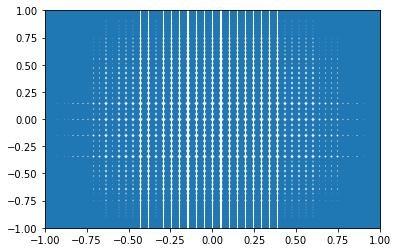

In [5]:
plt.scatter(grid_out[0], grid_out[1])
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.show()

let's plot the integration weights:

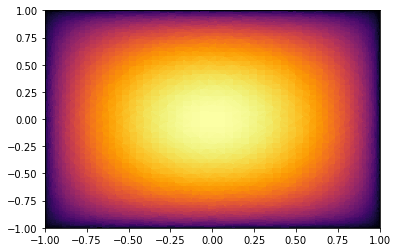

In [6]:
plt.tripcolor(grid_in[0], grid_in[1], weights, cmap=cmap)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.show()

we can also verify that they sum to the area of the reference element - 4:

In [7]:
weights.sum()

tensor(4.0000, dtype=torch.float64)

We can precompute the pre-shifted filters together with the integration rule:

In [8]:
weights.shape

torch.Size([4096])

In [9]:
from torch_harmonics import DiscreteContinuousConv2d

conv = DiscreteContinuousConv2d(1, 1, grid_in=grid_in, quad_weights=weights, grid_out=grid_out, kernel_shape=[2,4], radius_cutoff=0.1)
psi = conv.get_psi()

Let us check the sparsity pattern of the psi matrix:

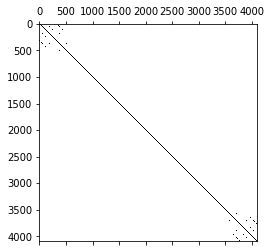

In [10]:
plt.spy(psi[0].to_dense())

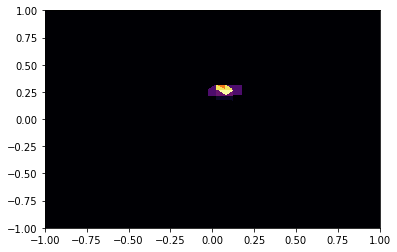

In [11]:
plt.tripcolor(grid_in[0], grid_in[1], psi[2, 2150].to_dense(), cmap=cmap, shading="flat")
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.show()

### testing the convolution

In [12]:
# let us get some test data:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/Albert_Einstein_Head.jpg/360px-Albert_Einstein_Head.jpg -O ./data/einstein.jpg

/home/bbonev/.zshenv:export:2: not valid in this context: :/usr/local/cuda-11.7/lib64
--2024-01-08 17:55:52--  https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/Albert_Einstein_Head.jpg/360px-Albert_Einstein_Head.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 185.15.59.240, 2a02:ec80:600:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|185.15.59.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52845 (52K) [image/jpeg]
Saving to: ‘./data/einstein.jpg’

./data/einstein.jpg 100%[===================>]  51.61K  --.-KB/s    in 0.02s   

2024-01-08 17:55:53 (2.23 MB/s) - ‘./data/einstein.jpg’ saved [52845/52845]



In [13]:
import imageio.v3 as iio

img = iio.imread('./data/einstein.jpg')
# interpolate onto 512x1024 grid:
data = nn.functional.interpolate(torch.from_numpy(img).unsqueeze(0).unsqueeze(0), size=(240,180)).squeeze().permute(1,0).flip(1).reshape(-1)

In [14]:
nx = 180
ny = 240

x_in = torch.linspace(0, 2, nx)
y_in = torch.linspace(0, 3, ny)

x_in, y_in = torch.meshgrid(x_in, y_in)
grid_in = torch.stack([x_in.reshape(-1), y_in.reshape(-1)])

# compute the correct quadrature weights
# IMPORTANT: this needs to be done right in order for the DISCO convolution to be normalized proeperly
w_x = 2*torch.ones_like(x_in) / nx
w_y = 3*torch.ones_like(y_in) / ny
weights = (w_x * w_y).reshape(-1)


In [15]:
data.shape

torch.Size([43200])

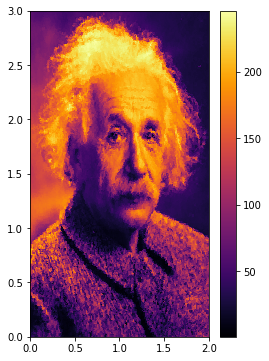

In [16]:
# Einstein on a grid
plt.figure(figsize=(4,6), )
plt.tripcolor(grid_in[0], grid_in[1], data, cmap=cmap)
plt.colorbar()
plt.xlim(0,2)
plt.ylim(0,3)
plt.show()

In [17]:
# generate the output grid
nx = 120
ny = 180

x_out = torch.linspace(0, 2, nx)
y_out = torch.linspace(0, 3, ny)

x_out, y_out = torch.meshgrid(x_out, y_out)
grid_out = torch.stack([x_out.reshape(-1), y_out.reshape(-1)])


In [18]:
conv = DiscreteContinuousConv2d(1, 1, grid_in=grid_in, quad_weights=weights, grid_out=grid_out, kernel_shape=[2,4], radius_cutoff=2*3./180)
# alternatively, btu normalization will be wrong due to the wrong domain [-1, 1]^2
# conv = DiscreteContinuousConv2d(1, 1, grid_in="lobatto", grid_out="lobatto", n_in=(180,240), n_out=(120,180), kernel_shape=[2,4], radius_cutoff=3./180).float()
conv.weight = nn.Parameter(torch.ones_like(conv.weight))
psi = conv.get_psi()

visualizing the Psi tensor reveals that it is the translated filter:

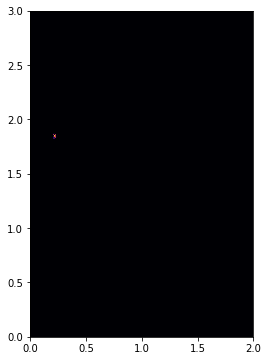

In [19]:
plt.figure(figsize=(4,6), )
plt.tripcolor(grid_in[0], grid_in[1], psi[0, 2450].to_dense(), cmap=cmap, shading="flat")
plt.xlim(0,2)
plt.ylim(0,3)
plt.show()

In [20]:
psi.shape

torch.Size([5, 21600, 43200])

In [21]:
# in order to compute the convolved image, we need to first bring it into the right shape with `batch_size x n_channels x n_grid_points`
out = conv(data.reshape(1, 1, -1))

let us now plot the oucome:

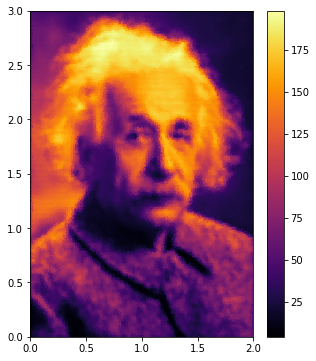

In [22]:
plt.figure(figsize=(5,6), )
plt.tripcolor(grid_out[0], grid_out[1], out.squeeze().detach(), cmap=cmap, shading="flat")
plt.colorbar()
plt.xlim(0,2)
plt.ylim(0,3)
plt.show()